In [1]:
import pandas as pd
import geopandas as gpd
import random as rd
from math import log, exp

In [2]:
# Cargamos nuestra ciudad sintética
cells = gpd.read_file('ciudad_sintetica.shp')
cells.head()

,cell,area,m2_op,acc_op_cam,acc_op_veh,geometry
0,1,25980.762114,1.496370,21.999698,3261.594956,"POLYGON ((0.000 1000.000, 100.000 1000.000, 15..."
1,2,25980.762114,0.293320,20.939344,3283.642413,"POLYGON ((0.000 826.795, 100.000 826.795, 150...."
2,3,25980.762114,3.416329,25.762190,3294.544635,"POLYGON ((0.000 653.590, 100.000 653.590, 150...."
3,4,25980.762114,16.222386,47.757336,3293.653747,"POLYGON ((0.000 480.385, 100.000 480.385, 150...."
4,5,25980.762114,8.038769,51.997028,3280.187080,"POLYGON ((0.000 307.180, 100.000 307.180, 150...."


In [3]:
# Agregamos Agentes H1 y H2 en nuestra ciudad, este paso es completamente
# sintético (Ustedes ya los tienen por medio de la foto de la ciudad desde el SII)
def gen_h1_h2(row, df):
    pond_h1 = (row['acc_op_veh']+row['acc_op_cam'])/(df['acc_op_veh'].sum()+df['acc_op_cam'].sum())
    pond_h2 = (row['acc_op_veh'])/df['acc_op_veh'].sum()
    h1 = 3*int(rd.expovariate(pond_h1))
    h2 = 4*int(rd.expovariate(pond_h2))
    return pd.Series([h1, h2])
cells[['h1','h2']] = cells.apply(lambda row: gen_h1_h2(row, cells), axis = 1)
cells.head()

,cell,area,m2_op,acc_op_cam,acc_op_veh,geometry,h1,h2
0,1,25980.762114,1.496370,21.999698,3261.594956,"POLYGON ((0.000 1000.000, 100.000 1000.000, 15...",246,40
1,2,25980.762114,0.293320,20.939344,3283.642413,"POLYGON ((0.000 826.795, 100.000 826.795, 150....",21,48
2,3,25980.762114,3.416329,25.762190,3294.544635,"POLYGON ((0.000 653.590, 100.000 653.590, 150....",45,108
3,4,25980.762114,16.222386,47.757336,3293.653747,"POLYGON ((0.000 480.385, 100.000 480.385, 150....",9,36
4,5,25980.762114,8.038769,51.997028,3280.187080,"POLYGON ((0.000 307.180, 100.000 307.180, 150....",471,296


<AxesSubplot:>

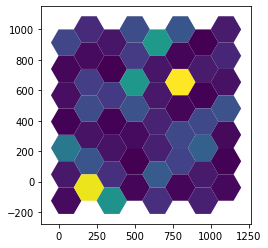

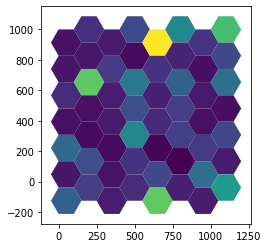

In [4]:
cells.plot(column = 'h1')
cells.plot(column = 'h2')

In [5]:
# Definimos funciones bhi (de DP) ficticias (ustedes las cargan desde BIOGEME)
bhi_h1 = lambda acc_cam, acc_veh, n_h2: 0.01*acc_cam - 0.0015*acc_veh - 0.002*n_h2 
bhi_h2 = lambda acc_cam, acc_veh, n_h2: 0.02*acc_cam - 0.0017*acc_veh + 0.003*n_h2 

## Inicio resolución Equilibrio

In [6]:
cells['s_i'] = cells['h1'] + cells['h2']
cells.head()

,cell,area,m2_op,acc_op_cam,acc_op_veh,geometry,h1,h2,s_i
0,1,25980.762114,1.496370,21.999698,3261.594956,"POLYGON ((0.000 1000.000, 100.000 1000.000, 15...",246,40,286
1,2,25980.762114,0.293320,20.939344,3283.642413,"POLYGON ((0.000 826.795, 100.000 826.795, 150....",21,48,69
2,3,25980.762114,3.416329,25.762190,3294.544635,"POLYGON ((0.000 653.590, 100.000 653.590, 150....",45,108,153
3,4,25980.762114,16.222386,47.757336,3293.653747,"POLYGON ((0.000 480.385, 100.000 480.385, 150....",9,36,45
4,5,25980.762114,8.038769,51.997028,3280.187080,"POLYGON ((0.000 307.180, 100.000 307.180, 150....",471,296,767


In [7]:
# Previo a iniciar

## H1 y H2 Obervado Sum(hh) en i
H1 = cells['h1'].sum()
H2 = cells['h2'].sum()
print(f"H1 observado: {H1}")
print(f"H2 observado: {H2}\n\n")

## Objetivos de H1 y H2
H1_obj = 9500
H2_obj = (H1+H2) - H1_obj
agentes = {'h1': H1_obj, 'h2': H2_obj}
print(f"H1 objetivo: {H1_obj}")
print(f"H2 objetivo: {H2_obj}")

## Parametros Mus
mu = 1
mu_oferta = 0.15

## B_h inical
b_h = {'h1': 0, 'h2': 0}

## Oferta total
S = cells['s_i'].sum()
print(f"Oferta total es: {S}")

H1 observado: 10674
H2 observado: 9828


H1 objetivo: 9500
H2 objetivo: 11002
Oferta total es: 20502


In [8]:
def renta(row):
    global agentes, mu, b_h
    
    suma = 0
    for h in agentes:
        suma += agentes[h]*exp(mu*(row[f'bhi_{h}']+ b_h[h]))
        
    r = 1/mu * log(suma)
    return r

In [9]:
iteraciones = [cells.copy()]
it = 1
while True:
    print(f'Iteración {it}')
    iteraciones.append(iteraciones[-1].copy())
    current = iteraciones[-1]
    
    # Calcular la matriz de los bhi (para cada hogar o agente)
    current['bhi_h1'] = current.apply(lambda row: bhi_h1(row['acc_op_cam'], row['acc_op_veh'], row['h2']), axis = 1)
    current['bhi_h2'] = current.apply(lambda row: bhi_h2(row['acc_op_cam'], row['acc_op_veh'], row['h2']), axis = 1)

    # Calcular las rentas por zona
    current['r_i'] = current.apply(lambda row: renta(row), axis = 1)
    
    # Calcular las probabilidades
    for h in agentes:
        current[f'phi_{h}'] = current.apply(lambda row: agentes[h]* exp(mu*(row[f'bhi_{h}'] + b_h[h] - row['r_i'])), axis = 1)
    
    # Actualizamos los agentes por zona
    for h in agentes:
        current[h] = current.apply(lambda row: row['s_i']*row[f'phi_{h}'], axis = 1)
        
    # Actualización de los b_h para la siguiente iteración
    for h in b_h:
        c = current.copy()
        c['sumando'] = c.apply(lambda row: row['s_i']*exp(mu*(row[f'bhi_{h}']-row['r_i'])), axis = 1)
        b_h[h] = -1/mu * log(c['sumando'].sum())
    
    current['err'] = abs(current['h1'] + current['h2'] - current['s_i'])
    error = current['err'].sum() + abs(current['h1'].sum()-agentes['h1']) + abs(current['h2'].sum()-agentes['h2'])
    
    print(f'    error: {error}')
    
    if error < 0.001:
        break
        
    current['exp_ri'] = current.apply(lambda row: exp(mu_oferta * row['r_i']), axis = 1)
    denominador = current['exp_ri'].sum()
    current['s_i'] = current.apply(lambda row: S*exp(mu_oferta * row['r_i'])/denominador, axis = 1)
    it +=1

Iteración 1
    error: 14939.852489406472
Iteración 2
    error: 9506.929804617383
Iteración 3
    error: 3063.3983464283665
Iteración 4
    error: 44.28310391634952
Iteración 5
    error: 1401.4118724467442
Iteración 6
    error: 1182.3677979821568
Iteración 7
    error: 640.2190493981898
Iteración 8
    error: 79.31565145787698
Iteración 9
    error: 150.39577416692
Iteración 10
    error: 188.32731390698476
Iteración 11
    error: 106.18196949018565
Iteración 12
    error: 31.82330335392544
Iteración 13
    error: 15.995182631654501
Iteración 14
    error: 24.68642769080202
Iteración 15
    error: 18.409948927062175
Iteración 16
    error: 6.308272147370019
Iteración 17
    error: 0.6511126837697248
Iteración 18
    error: 3.5988034915575327
Iteración 19
    error: 2.801192940517325
Iteración 20
    error: 1.4256679889744817
Iteración 21
    error: 0.09652435389949687
Iteración 22
    error: 0.37022146718942395
Iteración 23
    error: 0.4428645050495277
Iteración 24
    error: 0.223

<AxesSubplot:>

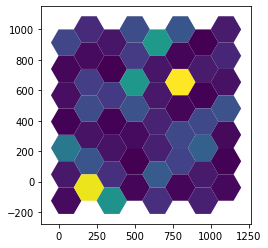

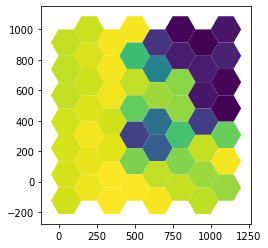

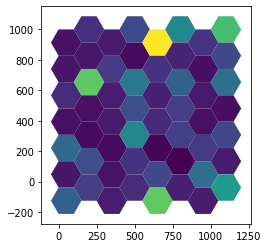

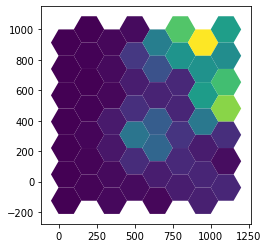

In [10]:
iteraciones[0].plot(column = 'h1')
iteraciones[-1].plot(column = 'h1')
iteraciones[0].plot(column = 'h2')
iteraciones[-1].plot(column = 'h2')